In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

In [33]:
covid_case = pd.read_csv("casos_hosp_uci_def_sexo_edad_provres.csv", keep_default_na=False)

In [34]:
covid_case.loc[covid_case["grupo_edad"]=="Oct-19", "grupo_edad"] = "10-19"

In [35]:
covid_case.head()

,provincia_iso,sexo,grupo_edad,fecha,num_casos,num_hosp,num_uci,num_def
0,A,H,0-9,2020-01-01,0,0,0,0
1,A,H,10-19,2020-01-01,0,0,0,0
2,A,H,20-29,2020-01-01,0,0,0,0
3,A,H,30-39,2020-01-01,0,0,0,0
4,A,H,40-49,2020-01-01,0,0,0,0


In [36]:
covid_case.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847470 entries, 0 to 847469
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   provincia_iso  847470 non-null  object
 1   sexo           847470 non-null  object
 2   grupo_edad     847470 non-null  object
 3   fecha          847470 non-null  object
 4   num_casos      847470 non-null  int64 
 5   num_hosp       847470 non-null  int64 
 6   num_uci        847470 non-null  int64 
 7   num_def        847470 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 51.7+ MB


From the overview of the dataset, it seems we don't have any missing data.

In [37]:
print("We have {} unique regional data".format(covid_case["provincia_iso"].nunique()))

We have 53 unique regional data


First let's change the date variable into appropriate **DATE** format and set it as index.

In [38]:
covid_case["fecha"] = pd.to_datetime(covid_case["fecha"], infer_datetime_format=True)
covid_case.set_index("fecha", inplace=True)

In [39]:
print("Our dataset time rage is displayed below.")
print(min(covid_case.index))
print(max(covid_case.index))

Our dataset time rage is displayed below.
2020-01-01 00:00:00
2021-06-16 00:00:00


# Explanatory Prediction

Now before we go to the prediction, let's see the distribution of our candidate target variables.

<AxesSubplot:xlabel='fecha'>

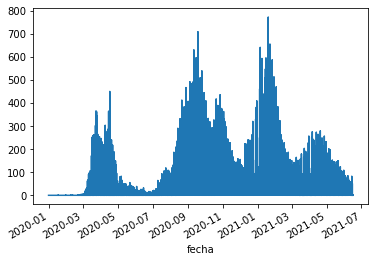

In [40]:
covid_case["num_casos"].plot()

<AxesSubplot:xlabel='fecha'>

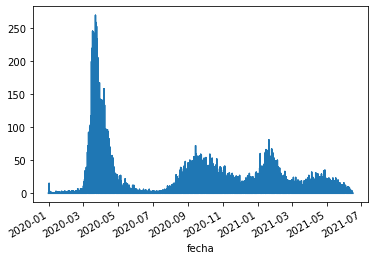

In [41]:
covid_case["num_hosp"].plot()

<AxesSubplot:xlabel='fecha'>

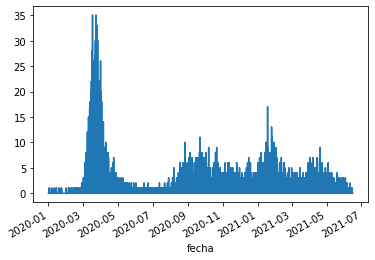

In [42]:
covid_case["num_uci"].plot()

## Analysis - National Level

In [44]:
national_data = covid_case.groupby(["fecha", "sexo", "grupo_edad"]).sum()

In [45]:
national_data

num_casos  num_hosp  num_uci  num_def
fecha      sexo grupo_edad                                       
2020-01-01 H    0-9                 0         0        0        0
                10-19               0         0        0        0
                20-29               0         0        0        0
                30-39               0         0        0        0
                40-49               0         0        0        0
...                               ...       ...      ...      ...
2021-06-16 NC   50-59               0         0        0        0
                60-69               0         0        0        0
                70-79               0         0        0        0
                80+                 0         0        0        0
                NC                  0         0        0        0

[15990 rows x 4 columns]

In [46]:
national_data["sexo"] = national_data.index.get_level_values(1)
national_data["grupo_edad"] = national_data.index.get_level_values(2)
national_data = national_data.droplevel(["sexo", "grupo_edad"])

In [47]:
national_data.head()

,num_casos,num_hosp,num_uci,num_def,sexo,grupo_edad
fecha,,,,,,
2020-01-01,0,0,0,0,H,0-9
2020-01-01,0,0,0,0,H,10-19
2020-01-01,0,0,0,0,H,20-29
2020-01-01,0,0,0,0,H,30-39
2020-01-01,0,0,0,0,H,40-49


In [48]:
national_data.iloc[7:9]

,num_casos,num_hosp,num_uci,num_def,sexo,grupo_edad
fecha,,,,,,
2020-01-01,0,1,0,0,H,70-79
2020-01-01,0,2,0,0,H,80+


OK now that we got data at a national level, we need to pick our target variable. Looking at the dataset, we fill hospitalization, ICU or deaths wouldn't really explain the epidemic dynamics because flagging the case first comes before any of the others in the evolution. But in order to make the cases as target and more explanatory, we should make it in a way that it must contain information included in **hospitalization, ICU and death**. For this to work, we came up with an idea that **number of cases is the sum of hospitalization and ICU minus number of deaths.**

  $Total No. of Cases = (No. of cases + No. of Hospitalization + No. of ICU) - No. of Death$

On top of this we should Label encode **Sex** and **Age range**.

In [49]:
from sklearn.preprocessing import LabelEncoder

In [50]:
# label encode sex and age range.
label_encoder = LabelEncoder()

national_data["sexo"] = label_encoder.fit_transform(national_data["sexo"])
national_data["grupo_edad"] = label_encoder.fit_transform(national_data["grupo_edad"])

In [51]:
# get valid number of cases.
def num_of_cases(case, hosp, icu, death):
  cases = case + hosp + icu - death
  return cases

In [52]:
national_data["num_casos"] = national_data.apply(lambda dataset: num_of_cases(national_data.num_casos,
                                                                              national_data.num_hosp, 
                                                                              national_data.num_uci, 
                                                                              national_data.num_def))

In [53]:
national_data.iloc[7:9]

,num_casos,num_hosp,num_uci,num_def,sexo,grupo_edad
fecha,,,,,,
2020-01-01,1,1,0,0,0,7
2020-01-01,2,2,0,0,0,8


Now that we have got what we needed, lets select a subset of certain data.

In [54]:
data_2021 = national_data[national_data.index >= pd.to_datetime("2021-01-01")].drop(["num_hosp", "num_uci", "num_def"], axis=1)

In order to get the prevalence, we went ahead and got the population size in Spain for year 2021. Link can be found [here](https://www.macrotrends.net/countries/ESP/spain/population#:~:text=The%20current%20population%20of%20Spain,a%200.09%25%20increase%20from%202018.)


In [55]:
population = 46_745_216

data_2021["num_casos_per_pop"] = data_2021["num_casos"].apply(lambda x: (x * 100_000)/population)
data_2021.drop("num_casos", axis=1, inplace=True)

In [56]:
data_2021.head()

,sexo,grupo_edad,num_casos_per_pop
fecha,,,
2021-01-01,0,0,0.492029
2021-01-01,0,1,0.735904
2021-01-01,0,2,1.178730
2021-01-01,0,3,1.125249
2021-01-01,0,4,1.416188


In [57]:
# Adding the lag of the target variable from 7 steps back up to 30 days
for i in range(28, 45):
    data_2021["lag_{}".format(i)] = data_2021.num_casos_per_pop.shift(i)

In [58]:
data_2021.head(10)

,sexo,grupo_edad,num_casos_per_pop,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44
fecha,,,,,,,,,,,,,,,,,,,,
2021-01-01,0,0,0.492029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,0,1,0.735904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,0,2,1.178730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,0,3,1.125249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,0,4,1.416188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,0,5,1.467530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,0,6,1.065350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,0,7,0.676005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,0,8,0.504864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [60]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [61]:
y = data_2021.dropna()["num_casos_per_pop"]
X = data_2021.dropna().drop(['num_casos_per_pop'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [62]:
# model building
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [63]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = np.clip(model.predict(X_test), 0, np.inf)
    
    plt.figure(figsize=(15, 7))
    plt.plot(X_test.index, prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(X_test.index, y_test.values, label="actual", linewidth=2.0)
    
    error = r2_score(y_test, prediction)
    plt.title("R2 error {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.xlabel("Variables")
    plt.ylabel("coef")
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

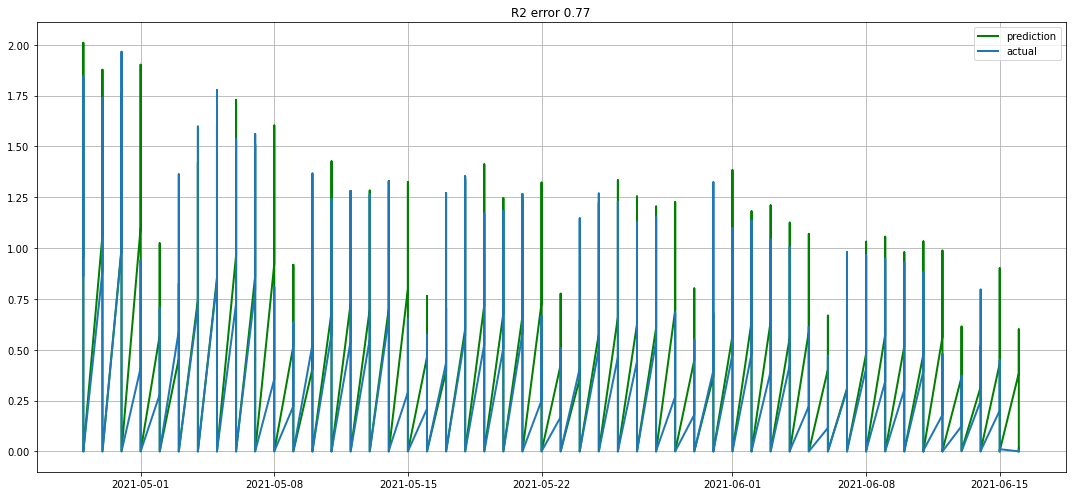

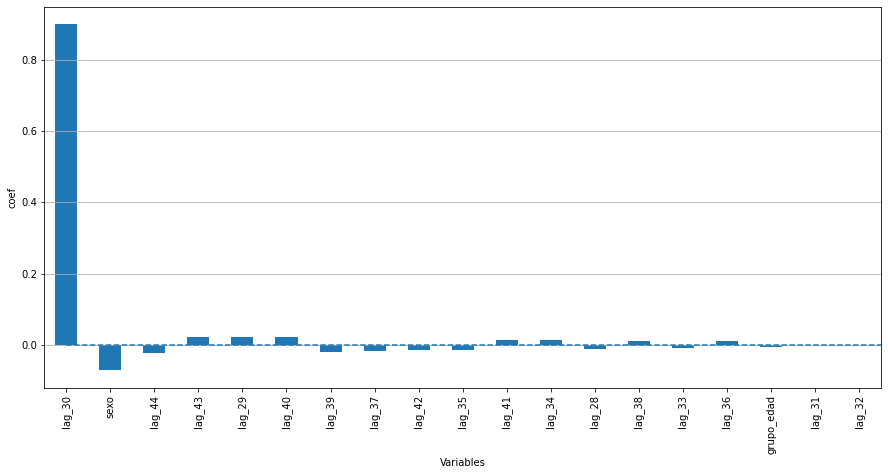

In [64]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

This is very interesting, we can see that **Sex, age range** has a higher **coefficient** values which makes them very significant in the model. But we need to scale the data since we don't have our independent variables in the same scale.

In [66]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

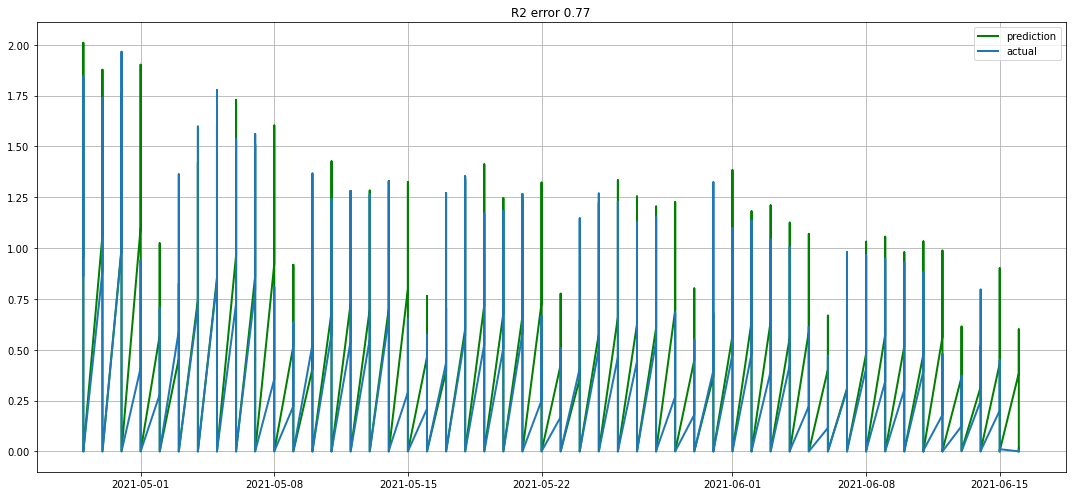

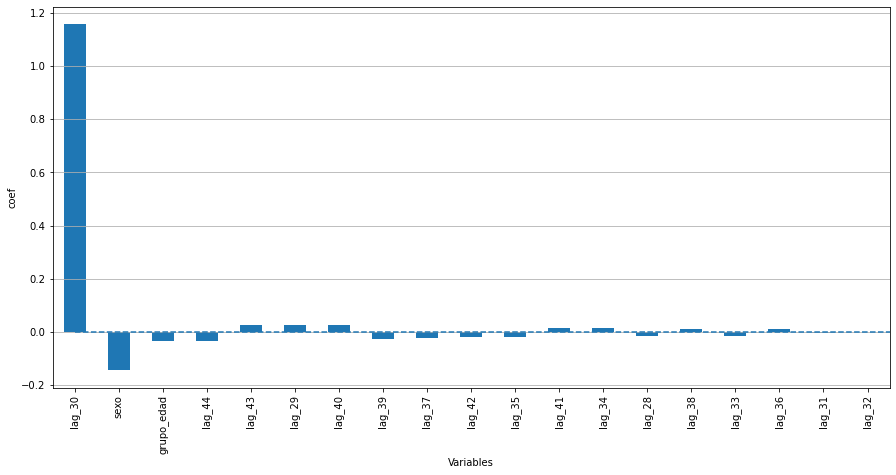

In [67]:
y = data_2021.dropna()["num_casos_per_pop"]
X = data_2021.dropna().drop(['num_casos_per_pop'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_train_scaled.index = X_train.index
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_test_scaled.index = X_test.index

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Now we clearly see which variables are important. One discovery is that for some reason **lag 30 and lag 44** seem to be very important in our model. Let's add extract date features and see if that helps more.

In [68]:
data_2021["day"] = data_2021.index.day
data_2021["month"] = data_2021.index.month
data_2021["weekday"] = data_2021.index.weekday
data_2021['is_weekend'] = data_2021.index.weekday.isin([5,6])*1
data_2021['week_of_year'] = data_2021.index.weekofyear
data_2021.tail()

,sexo,grupo_edad,num_casos_per_pop,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,...,lag_40,lag_41,lag_42,lag_43,lag_44,day,month,weekday,is_weekend,week_of_year
fecha,,,,,,,,,,,,,,,,,,,,,
2021-06-16,2,5,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.192533,0.408598,0.367952,0.363674,0.286660,16,6,2,0,24
2021-06-16,2,6,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.094127,0.192533,0.408598,0.367952,0.363674,16,6,2,0,24
2021-06-16,2,7,0.0,0.010696,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.027810,0.094127,0.192533,0.408598,0.367952,16,6,2,0,24
2021-06-16,2,8,0.0,0.000000,0.010696,0.000000,0.0,0.0,0.0,0.0,...,0.051342,0.027810,0.094127,0.192533,0.408598,16,6,2,0,24
2021-06-16,2,9,0.0,0.000000,0.000000,0.010696,0.0,0.0,0.0,0.0,...,0.079152,0.051342,0.027810,0.094127,0.192533,16,6,2,0,24


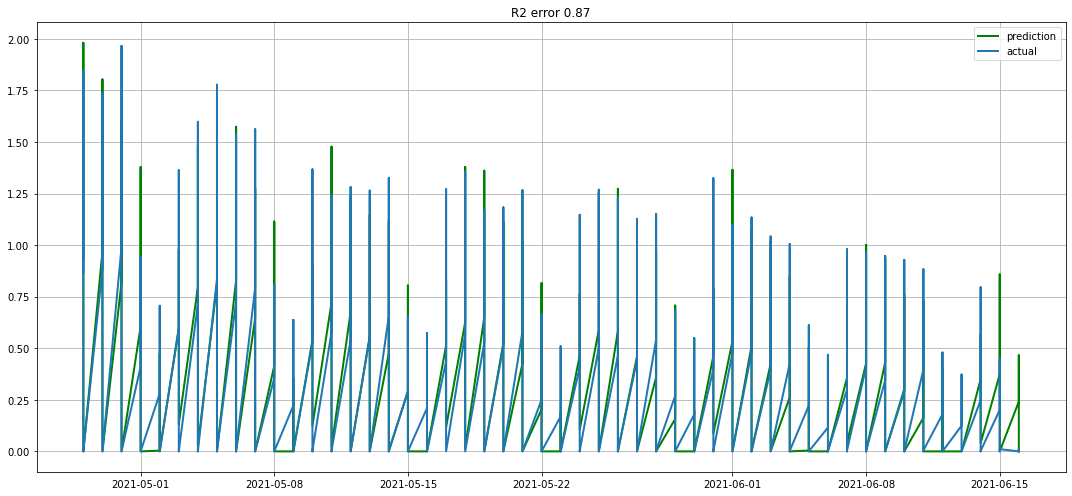

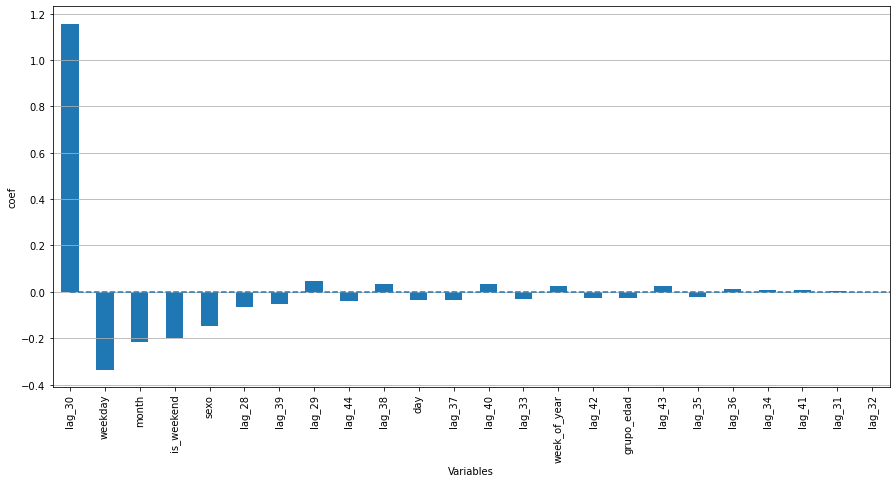

In [69]:
y = data_2021.dropna()["num_casos_per_pop"]
X = data_2021.dropna().drop(['num_casos_per_pop'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_train_scaled.index = X_train.index
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_test_scaled.index = X_test.index

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

# Prediction for 7 Days.

We will be taking the last 7 days in year 2021 for the prediction and we'll use 45 days of data to predict 7 days in the future.

In [70]:
max(data_2021.index)

Timestamp('2021-06-16 00:00:00')

In [71]:
test_split_date = pd.to_datetime("2021-06-09")
train_split_date = pd.to_datetime("2021-04-24")
pred_data = national_data[national_data.index > train_split_date].drop(["num_hosp", "num_uci", "num_def"], axis=1)

In [72]:
pred_data

,num_casos,sexo,grupo_edad
fecha,,,
2021-04-25,189,0,0
2021-04-25,257,0,1
2021-04-25,236,0,2
2021-04-25,295,0,3
2021-04-25,401,0,4
...,...,...,...
2021-06-16,0,2,5
2021-06-16,0,2,6
2021-06-16,0,2,7


### Calculate case per population

In [73]:
population = 46_745_216

pred_data["num_casos_per_pop"] = pred_data["num_casos"].apply(lambda x: (x * 100_000)/population)
pred_data.drop("num_casos", axis=1, inplace=True)

In [74]:
# Adding the lag of the target variable from 28 steps back up to 45 days
for i in range(28, 45):
    pred_data["lag_{}".format(i)] = pred_data.num_casos_per_pop.shift(i)

In [75]:
test_data = pred_data[pred_data.index > test_split_date]
train_data = pred_data[(pred_data.index > train_split_date) & (pred_data.index <= test_split_date)]

In [76]:
train_data.tail()

,sexo,grupo_edad,num_casos_per_pop,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44
fecha,,,,,,,,,,,,,,,,,,,,
2021-06-09,2,5,0.002139,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.021393,0.070595,0.074874,0.226761,0.496307,0.877095,0.819335,0.727347,0.682423
2021-06-09,2,6,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.021393,0.070595,0.074874,0.226761,0.496307,0.877095,0.819335,0.727347
2021-06-09,2,7,0.000000,0.002139,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.021393,0.070595,0.074874,0.226761,0.496307,0.877095,0.819335
2021-06-09,2,8,0.000000,0.344420,0.002139,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.021393,0.070595,0.074874,0.226761,0.496307,0.877095
2021-06-09,2,9,0.000000,0.665309,0.344420,0.002139,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.021393,0.070595,0.074874,0.226761,0.496307


In [77]:
test_data.head()

,sexo,grupo_edad,num_casos_per_pop,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44
fecha,,,,,,,,,,,,,,,,,,,,
2021-06-10,0,0,0.303774,0.862120,0.665309,0.344420,0.002139,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.021393,0.070595,0.074874,0.226761
2021-06-10,0,1,0.624663,0.821474,0.862120,0.665309,0.344420,0.002139,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.021393,0.070595,0.074874
2021-06-10,0,2,0.928437,0.821474,0.821474,0.862120,0.665309,0.344420,0.002139,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.021393,0.070595
2021-06-10,0,3,0.772272,0.504864,0.821474,0.821474,0.862120,0.665309,0.344420,0.002139,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.021393
2021-06-10,0,4,0.883513,0.224622,0.504864,0.821474,0.821474,0.862120,0.665309,0.344420,0.002139,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


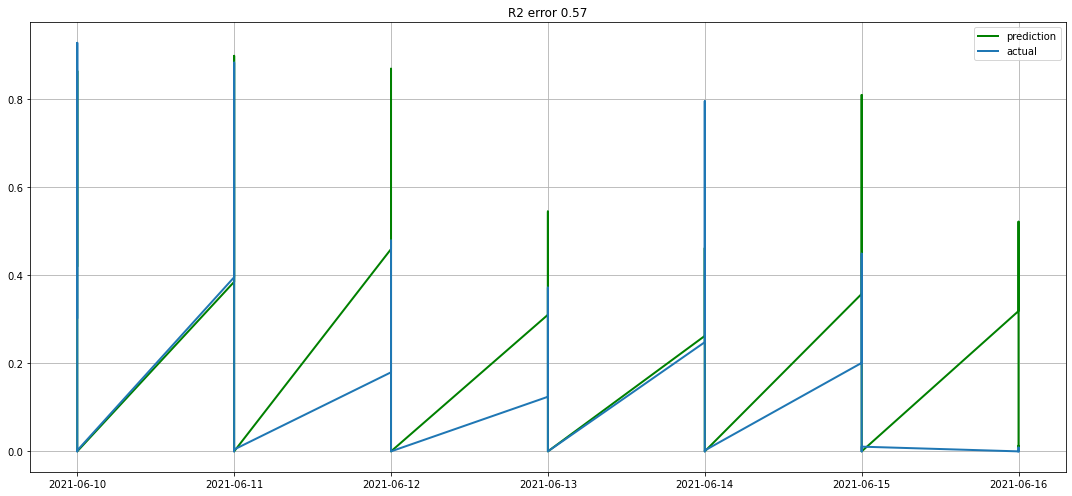

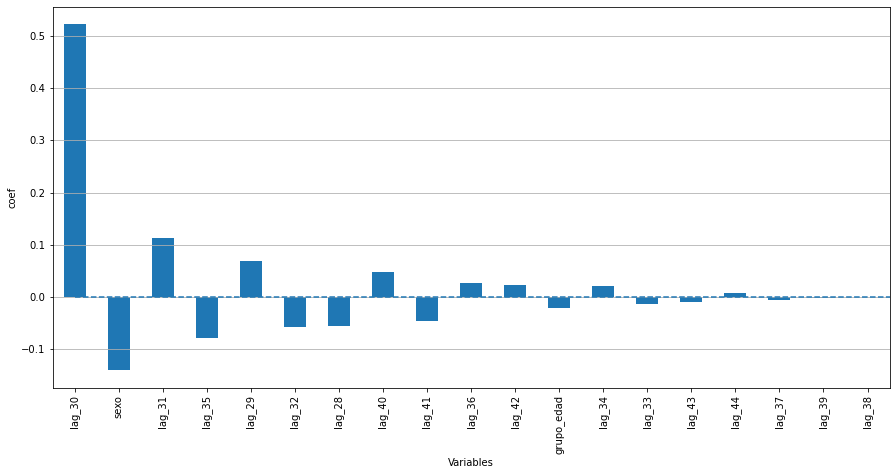

In [78]:
y_train = train_data.dropna()["num_casos_per_pop"]
X_train = train_data.dropna().drop(['num_casos_per_pop'], axis=1)

y_test = test_data.dropna()["num_casos_per_pop"]
X_test = test_data.dropna().drop(["num_casos_per_pop"], axis=1)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_train_scaled.index = X_train.index
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_test_scaled.index = X_test.index

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [79]:
import statsmodels.api as sm

sm.add_constant(X_train)
mod = sm.OLS(y_train, X_train)
res = mod.fit()

In [80]:
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:      num_casos_per_pop   R-squared (uncentered):                   0.901
Model:                            OLS   Adj. R-squared (uncentered):              0.899
Method:                 Least Squares   F-statistic:                              628.9
Date:                Fri, 16 Jul 2021   Prob (F-statistic):                        0.00
Time:                        18:34:19   Log-Likelihood:                          338.80
No. Observations:                1336   AIC:                                     -639.6
Df Residuals:                    1317   BIC:                                     -540.8
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [81]:
from sklearn.metrics import r2_score
pred = res.predict(X_test)

r2 = r2_score(y_test, pred)
r2

0.6471521795943027